

# Gender Classification with SimpleCNN and pre-trained RestNet-18 on CelebA Dataset 
## GAN (Generative Adversarial Network) to generate realistic synthetic data  such as face
## CycleGAN (Cycle-Consistent GAN) for image-to-image translation tasks, such as converting photos to cartoons


# -----------------------------
# 1. Imports and Device Setup
# -----------------------------

In [1]:
# -----------------------------
# 1. Imports and Device Setup
# -----------------------------

# PyTorch core libraries.
import torch                      # Main PyTorch library for tensor operations.
import torch.nn as nn             # Neural network module for building models.
import torch.nn.functional as F   # Functional API for activations, etc.
import torch.optim as optim       # Optimizers for training models.

# Data handling and DataLoader.
from torch.utils.data import DataLoader, Subset, random_split  # Data utilities.

# Torchvision for computer vision tasks.
import torchvision                # Main torchvision package.
import torchvision.transforms as transforms  # For image transformations.
import torchvision.models as models          # Pre-trained models like ResNet, etc.

# Additional libraries.
import numpy as np              # For numerical operations.
import matplotlib.pyplot as plt # For plotting and visualization.
import cv2                     # OpenCV for image processing.

# Enable loading of truncated images.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import Image

# Evaluation Metrics for Gender Detection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# A high-level outline for CycleGAN components:
import itertools


# -----------------------------
# Device Setup: Optimize Computations
# -----------------------------
# The device is determined in order of preference: CUDA (NVIDIA GPU), then MPS (Apple Silicon) and CPU.
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
                      else "cpu")
print(f"Using device: {device}")

Using device: mps


# -----------------------------
# Utility Functions
# -----------------------------

In [2]:
# -----------------------------
# Utility Functions
# -----------------------------

def show_sample_images(dataset, title, num_images=4):
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        img, _ = dataset[i]
        # Convert image tensor to NumPy (denormalize first)
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


def visualize_augmentation(dataset, index=0, num_variants=5):
    # Get the original image from the PIL loader (without transform)
    original_img, _ = dataset[index]  # using dataset before transformations if possible
    # If using a dataset with a transform already applied, you might reapply the transform manually.
    plt.figure(figsize=(15, 3))
    for i in range(num_variants):
        img, _ = dataset[index]  # reloading will get a new augmentation variant if transform has randomness
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
        plt.subplot(1, num_variants, i+1)
        plt.imshow(img)
        plt.title(f'Aug Variant {i+1}')
        plt.axis('off')
    plt.suptitle("Different Augmentation Variants")
    plt.show()

# -----------------------------
# 2. Data Preparation and Preprocessing
# -----------------------------

Train samples: 8000, Validation samples: 1000, Test samples: 1000


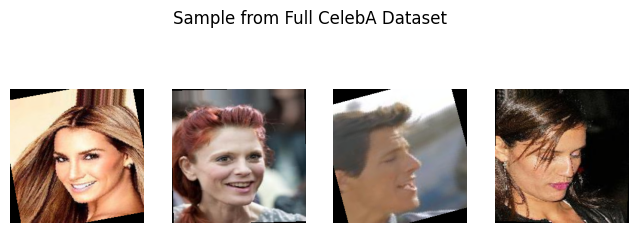

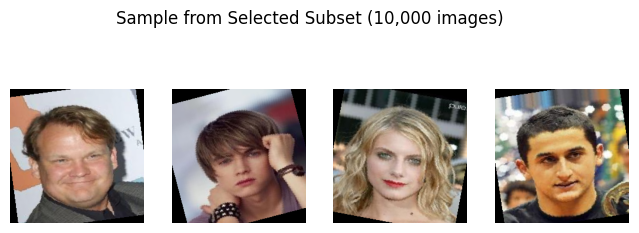

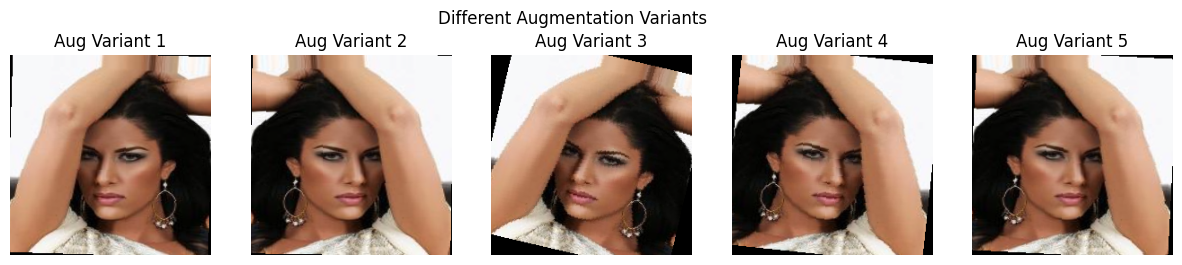

In [3]:

# -----------------------------
# 2. Data Preparation and a Safe CelebA Dataset
# -----------------------------


# Define transforms.
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset wrapper to handle read errors.
class SafeCelebA(torchvision.datasets.CelebA):
    def __getitem__(self, index):
        try:
            sample = super().__getitem__(index)
        except Exception as e:
            print(f"Error loading image at index {index}: {e}")
            # Create a dummy image and target.
            dummy_img = Image.new("RGB", (224, 224))
            dummy_target = (None, None, None, None, torch.zeros(40))
            sample = (dummy_img, dummy_target)
        return sample

# Load the dataset using the safe wrapper.
data_root = './data'
celeba_dataset = SafeCelebA(root=data_root, split='all', download=True,
                            transform=train_transforms)

# Use a subset to speed up training.
subset_size = 10000  
indices = np.random.choice(len(celeba_dataset), subset_size, replace=False)
subset_dataset = Subset(celeba_dataset, indices)

# Split into training (80%), validation (10%), testing (10%).
train_size = int(0.8 * subset_size)
val_size = int(0.1 * subset_size)
test_size = subset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_size, val_size, test_size])

# Create DataLoaders (with num_workers=0 for simplicity).
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

# Visualize the full dataset:
show_sample_images(celeba_dataset, title="Sample from Full CelebA Dataset")

# Visualize subset:
show_sample_images(subset_dataset, title="Sample from Selected Subset (10,000 images)")

# Visualize augmentation on a sample image from training set.
visualize_augmentation(train_dataset, index=0, num_variants=5)

# -----------------------------
# 3. CNN Modeling
# -----------------------------

In [4]:

# -----------------------------
# 3. CNN Modeling
# -----------------------------

# (a) Simple CNN from scratch for binary gender classification.
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=1):  # Output: a single logit for binary classification.
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate and transfer SimpleCNN to the selected device.
model_scratch = SimpleCNN(num_classes=1).to(device)

# -----------------------------
# 3. Fine-tuning a Pre-trained ResNet-18 for binary gender classification.
# -----------------------------

# (b) Fine-tuning a Pre-trained ResNet-18 for binary gender classification.
model_pretrained = models.resnet18(pretrained=True)
# Optionally freeze pre-trained layers.
for param in model_pretrained.parameters():
    param.requires_grad = False
# Replace the final fully connected layer.
num_features = model_pretrained.fc.in_features
model_pretrained.fc = nn.Linear(num_features, 1)  # Single output for binary classification.
# Ensure new layer's parameters are trainable.
for param in model_pretrained.fc.parameters():
    param.requires_grad = True

model_pretrained = model_pretrained.to(device)


/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# -----------------------------
# 4. Model Training and Hyperparameter Tuning
# -----------------------------

Training SimpleCNN model...
Epoch [1/10], Train Loss: 0.5971, Val Loss: 0.7913
Best model saved to best_model_scratch.pth
Epoch [2/10], Train Loss: 0.5729, Val Loss: 0.6595
Best model saved to best_model_scratch.pth
Epoch [3/10], Train Loss: 0.5417, Val Loss: 0.6040
Best model saved to best_model_scratch.pth
Epoch [4/10], Train Loss: 0.5012, Val Loss: 0.5170
Best model saved to best_model_scratch.pth
Epoch [5/10], Train Loss: 0.4675, Val Loss: 0.4646
Best model saved to best_model_scratch.pth
Epoch [6/10], Train Loss: 0.4594, Val Loss: 0.4408
Best model saved to best_model_scratch.pth
Epoch [7/10], Train Loss: 0.4297, Val Loss: 0.3945
Best model saved to best_model_scratch.pth
Epoch [8/10], Train Loss: 0.4093, Val Loss: 0.4121
Epoch [9/10], Train Loss: 0.4073, Val Loss: 0.4685
Epoch [10/10], Train Loss: 0.3873, Val Loss: 0.4127
Early stopping triggered


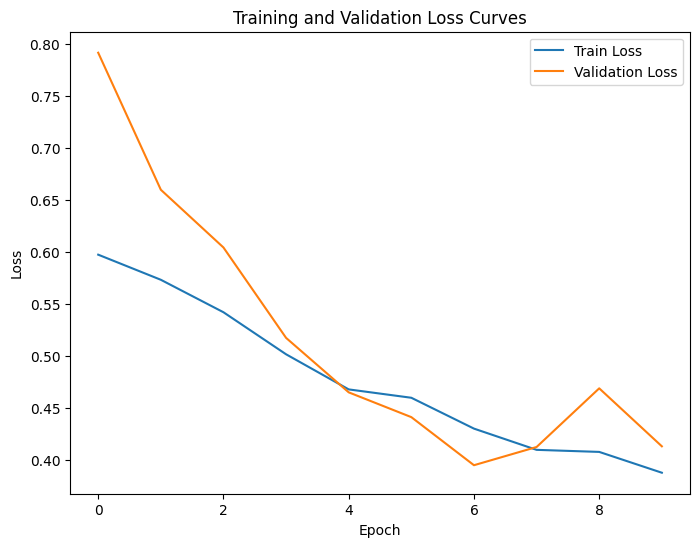

Training fine-tuned ResNet-18 model...
Epoch [1/10], Train Loss: 0.3572, Val Loss: 0.2745
Best model saved to best_model_resnet18.pth
Epoch [2/10], Train Loss: 0.2699, Val Loss: 0.2577
Best model saved to best_model_resnet18.pth
Epoch [3/10], Train Loss: 0.2505, Val Loss: 0.2371
Best model saved to best_model_resnet18.pth
Epoch [4/10], Train Loss: 0.2413, Val Loss: 0.2275
Best model saved to best_model_resnet18.pth
Epoch [5/10], Train Loss: 0.2343, Val Loss: 0.2141
Best model saved to best_model_resnet18.pth
Epoch [6/10], Train Loss: 0.2318, Val Loss: 0.2241
Epoch [7/10], Train Loss: 0.2290, Val Loss: 0.2184
Epoch [8/10], Train Loss: 0.2263, Val Loss: 0.2182
Early stopping triggered


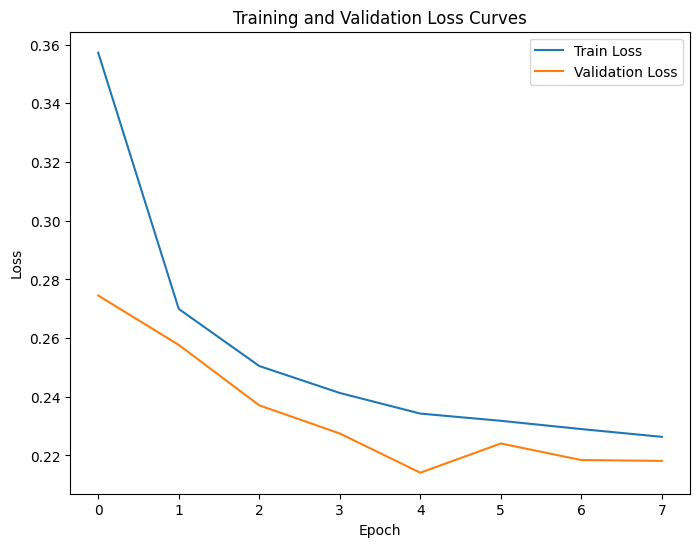

In [6]:
# -----------------------------
# 4. Model Training, Hyperparameter Tuning, and Saving Best Model ################## NEW ##############
# -----------------------------
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3, save_path=None):
    criterion = nn.BCEWithLogitsLoss()  # For binary classification.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience = 3  # Early stopping patience.
    patience_counter = 0

    # Initialize loss history for plotting
    loss_history_train = []
    loss_history_val = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for imgs, target in train_loader:
            imgs = imgs.to(device)
            # Extract only the "Male" attribute and move to device.
            if isinstance(target, torch.Tensor):
                # When target is a tensor, shape is [batch_size, 40]
                attrs = target[:, 20].float().unsqueeze(1).to(device)
            elif isinstance(target, (list, tuple)):
                # When using a tuple (e.g. from a safe dataset), assume index 4 holds the attribute tensor.
                attrs = target[4][:, 20].float().unsqueeze(1).to(device)
            else:
                raise TypeError("Unexpected target type")
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, attrs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        loss_history_train.append(avg_train_loss)
        
        # Validation step.
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, target in val_loader:
                imgs = imgs.to(device)
                if isinstance(target, torch.Tensor):
                    attrs = target[:, 20].float().unsqueeze(1).to(device)
                elif isinstance(target, (list, tuple)):
                    attrs = target[4][:, 20].float().unsqueeze(1).to(device)
                else:
                    raise TypeError("Unexpected target type")
                
                outputs = model(imgs)
                loss = criterion(outputs, attrs)
                val_loss += loss.item() * imgs.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        loss_history_val.append(avg_val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping check.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model = model.state_dict()
            # Save best model if a save path is provided.
            if save_path is not None:
                torch.save(best_model, save_path)
                print(f"Best model saved to {save_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
                
    model.load_state_dict(best_model)
    
    # Plot the loss curves.
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history_train, label="Train Loss")
    plt.plot(loss_history_val, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.show()
    
    return model

# Example usage:
print("Training SimpleCNN model...")
model_scratch = train_model(model_scratch, train_loader, val_loader, num_epochs=10, learning_rate=1e-3, save_path="best_model_scratch.pth")

print("Training fine-tuned ResNet-18 model...")
model_pretrained = train_model(model_pretrained, train_loader, val_loader, num_epochs=10, learning_rate=1e-3, save_path="best_model_resnet18.pth")


# -----------------------------
# 5. GradCAM Implementation for Model Interpretability
# -----------------------------

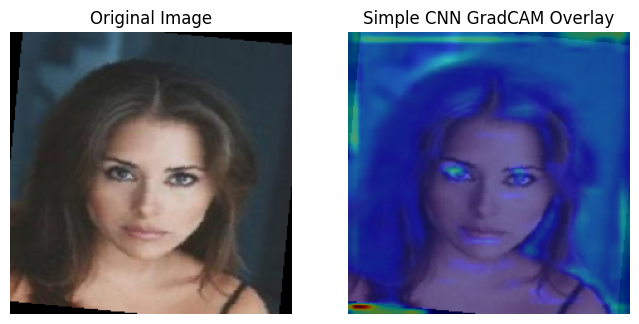

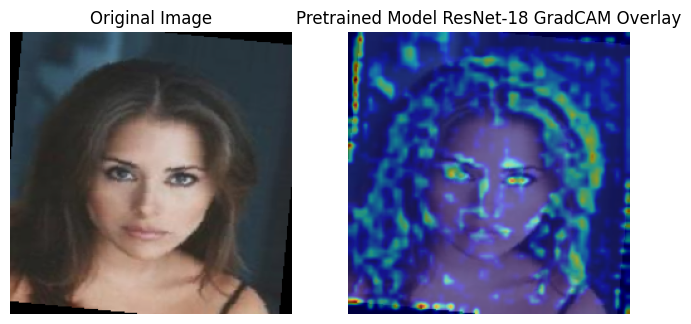

In [126]:

# -----------------------------
# 5. GradCAM Implementation for Model Interpretability
# -----------------------------

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_tensor, target_class=None):
        # Enable gradient computation on the input.
        input_tensor.requires_grad_()
        self.model.eval()
        
        # Forward pass.
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output, dim=1)
        
        self.model.zero_grad()
        # Compute a loss by summing the outputs; adjust if using multi-class.
        loss = output[:, 0].sum()
        loss.backward(retain_graph=True)
        
        # Ensure gradients were captured.
        if self.gradients is None:
            raise ValueError("Gradients are None. Ensure input_tensor.requires_grad() is True and check your target layer.")
        
        # Global Average Pooling on gradients.
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        # Resize CAM to the input image's spatial size.
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (input_tensor.size(2), input_tensor.size(3)))
        # Normalize.
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
        return cam




target_layer_scratch = model_scratch.features[8]
gradcam_scratch = GradCAM(model_scratch, target_layer_scratch)

target_layer_pretrained = model_pretrained.layer1[1].conv2
gradcam_pretrained = GradCAM(model_pretrained, target_layer_pretrained)

# Visualize GradCAM on one sample image:
dataiter = iter(test_loader)
images, targets = next(dataiter)
input_img = images[0].unsqueeze(0).to(device)

cam_heatmap_scratch = gradcam_scratch.generate_cam(input_img)
cam_heatmap_pretrained = gradcam_pretrained.generate_cam(input_img)

# Convert the tensor image to a NumPy image.
img_np = input_img.squeeze().cpu().permute(1, 2, 0).detach().numpy()
img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
img_np = np.clip(img_np, 0, 1)

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_np)
plt.imshow(cam_heatmap_scratch, cmap='jet', alpha=0.5)
plt.title("Simple CNN GradCAM Overlay")
plt.axis('off')
plt.show()


plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_np)
plt.imshow(cam_heatmap_pretrained, cmap='jet', alpha=0.5)
plt.title("Pretrained Model ResNet-18 GradCAM Overlay")
plt.axis('off')
plt.show()

# -----------------------------
# 6. Evaluation Metrics for Gender Detection
# -----------------------------

Evaluating Simple CNN...
Accuracy: 0.7910, Precision: 0.6938, Recall: 0.8753, F1 Score: 0.7741

Evaluating Pretrained ResNet-18 ...
Accuracy: 0.9000, Precision: 0.8652, Recall: 0.8949, F1 Score: 0.8798


/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


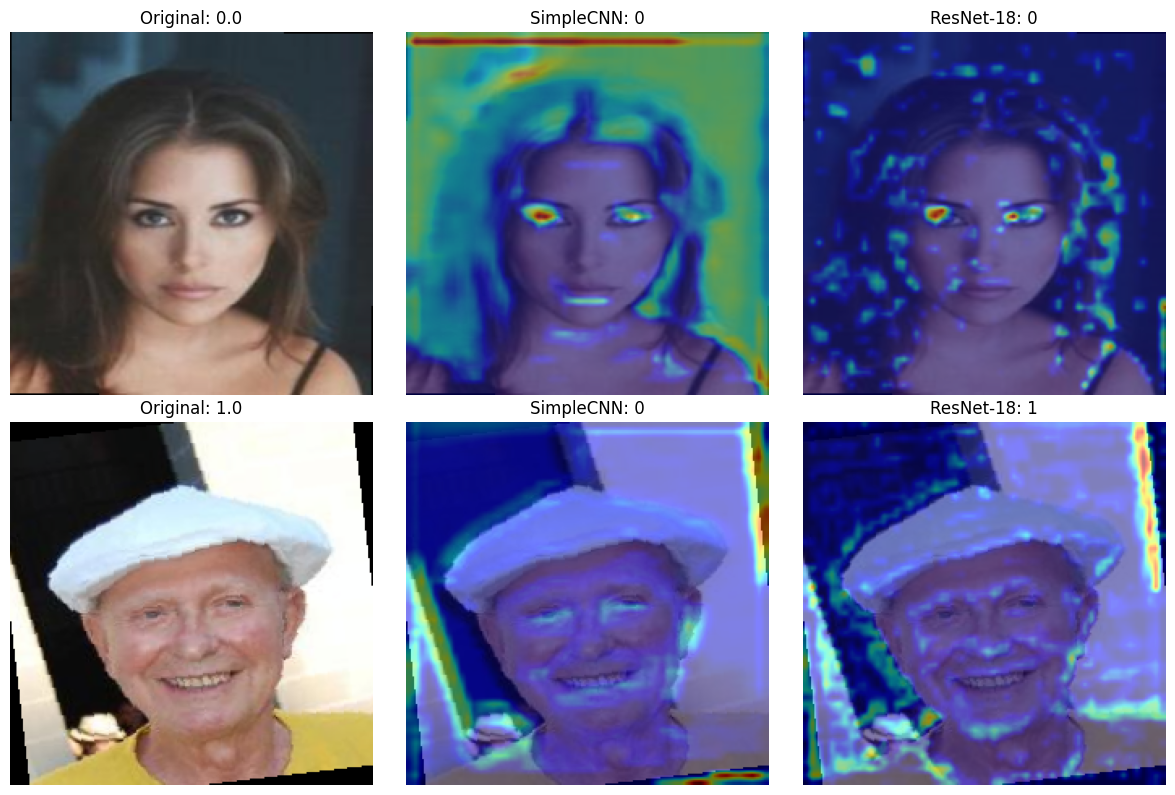

In [120]:

# -----------------------------
# 6. Evaluation Metrics for Gender Detection
# -----------------------------

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for imgs, target in data_loader:
            imgs = imgs.to(device)
            if isinstance(target, torch.Tensor):
                labels = target[:, 20].float().unsqueeze(1).to(device)
            elif isinstance(target, (list, tuple)):
                labels = target[4][:, 20].float().unsqueeze(1).to(device)
            else:
                raise TypeError("Unexpected target type")
                
            outputs = model(imgs)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).int().cpu().numpy()
            labels = labels.cpu().numpy()
            all_labels.extend(labels)
            all_preds.extend(preds)
            
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")



# Evaluation (Visualizing Predictions, Misclassification, and GradCAM)
def visualize_predictions(models, model_names, data_loader, gradcams, num_images=8):
    """
    models: list of models to compare.
    model_names: list of model names corresponding to models.
    data_loader: test data loader.
    gradcams: list of GradCAM objects corresponding to each model. If a model does not have GradCAM implemented, pass None.
    """
    # Get a batch from test loader
    images, targets = next(iter(data_loader))
    images = images.to(device)
    # Extract the "Male" attribute as ground truth.
    if isinstance(targets, torch.Tensor):
        labels = targets[:, 20].float().unsqueeze(1).to(device)
    else:
        labels = targets[4][:, 20].float().unsqueeze(1).to(device)
    
    # Get predictions from each model.
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            predictions.append(preds.cpu().numpy())
    
    # For visualization, select the first num_images.
    images = images[:num_images].cpu()
    labels = labels[:num_images].cpu().numpy().flatten()
    preds_model1 = predictions[0][:num_images].flatten()
    preds_model2 = predictions[1][:num_images].flatten() if len(predictions) > 1 else None
    
    # Plot images, ground truth, predictions, and GradCAM overlays.
    plt.figure(figsize=(16, 4 * num_images))
    for i in range(num_images):

        # Original image.
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
        
        plt.subplot(num_images, 4, i * 4 +1)
        plt.imshow(img)
        plt.title(f"Original: {labels[i]}")
        plt.axis('off')

        
        # Prediction from Model 1.
        cam = gradcams[0].generate_cam(images[i].unsqueeze(0).to(device))
        plt.subplot(num_images, 4, i * 4 + 2)
        plt.imshow(img)
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title(f"{model_names[0]}: {preds_model1[i]}")
        plt.axis('off')

        
        # Prediction from Model 2, if provided.
        if preds_model2 is not None:
            cam = gradcams[1].generate_cam(images[i].unsqueeze(0).to(device))
            plt.subplot(num_images, 4, i * 4 + 3)
            plt.imshow(img)
            plt.imshow(cam, cmap='jet', alpha=0.5)
            plt.title(f"{model_names[1]}: {preds_model2[i]}")
            plt.axis('off')
        else:
            plt.subplot(num_images, 4, i * 4 + 3)
            plt.text(0.5, 0.5, "N/A", fontsize=12, ha="center")
            plt.axis('off')
        

        # # GradCAM overlay from the first model (you can extend to each model).
        # if gradcams[0] is not None:
        #     cam = gradcams[0].generate_cam(images[i].unsqueeze(0).to(device))
        #     plt.subplot(num_images, 4, i * 4 + 4)
        #     plt.imshow(img)
        #     plt.imshow(cam, cmap='jet', alpha=0.5)
        #     plt.title(f"{model_names[0]}: GradCAM")
        #     plt.axis('off')
        # else:
        #     plt.subplot(num_images, 4, i * 4 + 4)
        #     plt.text(0.5, 0.5, "No GradCAM", fontsize=12, ha="center")
        #     plt.axis('off')


        # if gradcams[1] is not None:
        #     cam = gradcams[1].generate_cam(images[i].unsqueeze(0).to(device))
        #     plt.subplot(num_images, 4, i * 4 + 5)
        #     plt.imshow(img)
        #     plt.imshow(cam, cmap='jet', alpha=0.5)
        #     plt.title(f"{model_names[1]}: GradCAM")
        #     plt.axis('off')
        # else:
        #     plt.subplot(num_images, 4, i * 4 + 5)
        #     plt.text(0.5, 0.5, "No GradCAM", fontsize=12, ha="center")
        #     plt.axis('off')

    plt.tight_layout()
    plt.show()






print("Evaluating Simple CNN...")
evaluate_model(model_scratch, test_loader)

print("\nEvaluating Pretrained ResNet-18 ...")
evaluate_model(model_pretrained, test_loader)

visualize_predictions([model_scratch, model_pretrained],
                      ["SimpleCNN", "ResNet-18"],
                      test_loader,
                      [gradcam_scratch, gradcam_pretrained],
                      num_images=2)


# -----------------------------
# Add on 1. Generating Realistic Human Faces using a GAN
# -----------------------------

In [ ]:
# -----------------------------
# Add on 1. Generating Realistic Human Faces using a GAN
# -----------------------------

# Generator network.
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (nc) x 64 x 64 (you might need to adjust dimensions, e.g., to 224 x 224)
        )
        
    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),   # -> (ndf) x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # -> (ndf*2) x 16 x 16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), # -> (ndf*4) x 8 x 8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),        # -> (1) x 5 x 5 (for 64x64 input)
            nn.AdaptiveAvgPool2d((1,1)),                        # -> (1) x 1 x 1
            nn.Sigmoid()
        )
        
    def forward(self, input):
        out = self.main(input)    # shape: [batch_size, 1, 1, 1]
        return out.view(input.size(0))  # reshape to [batch_size]


# Instantiate generator and discriminator.
nz = 100  # size of latent vector
netG = Generator(nz=nz).to(device)
netD = Discriminator().to(device)

# Loss and optimizers.
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Placeholder training loop (for demonstration; actual training on CelebA takes many epochs).
import time

num_epochs_gan = 5  # reduce for quick demonstration
for epoch in range(num_epochs_gan):
# In your training loop:
    for i, (imgs, _) in enumerate(train_loader):
        # Resize images to 64x64 if needed.
        imgs = torch.nn.functional.interpolate(imgs, size=(64, 64))
        real = imgs.to(device)
        b_size = real.size(0)
        
        # Create labels matching the discriminator output shape [b_size].
        real_label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        fake_label = torch.full((b_size,), 0., dtype=torch.float, device=device)
        
        # Update Discriminator.
        netD.zero_grad()
        output = netD(real)
        loss_D_real = criterion(output, real_label)
        loss_D_real.backward()
        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        output = netD(fake.detach())
        loss_D_fake = criterion(output, fake_label)
        loss_D_fake.backward()
        
        optimizerD.step()
        
        # Update Generator.
        netG.zero_grad()
        output = netD(fake)
        loss_G = criterion(output, real_label)
        loss_G.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs_gan}][{i}/{len(train_loader)}] Loss_D: {(loss_D_real+loss_D_fake).item():.4f} Loss_G: {loss_G.item():.4f}")
    # Optionally save generated samples every epoch
    time.sleep(0.1)


[0/5][0/250] Loss_D: 1.3847 Loss_G: 1.0380
[0/5][100/250] Loss_D: 0.1244 Loss_G: 4.2186
[0/5][200/250] Loss_D: 0.4246 Loss_G: 2.9321
[1/5][0/250] Loss_D: 0.5508 Loss_G: 2.2064
[1/5][100/250] Loss_D: 0.5021 Loss_G: 3.3104
[1/5][200/250] Loss_D: 0.8227 Loss_G: 1.7546
[2/5][0/250] Loss_D: 0.9812 Loss_G: 4.3403
[2/5][100/250] Loss_D: 0.4768 Loss_G: 2.3132
[2/5][200/250] Loss_D: 0.5564 Loss_G: 3.9383
[3/5][0/250] Loss_D: 0.4385 Loss_G: 3.0872
[3/5][100/250] Loss_D: 0.4731 Loss_G: 2.5847
[3/5][200/250] Loss_D: 0.4566 Loss_G: 2.8004
[4/5][0/250] Loss_D: 0.6177 Loss_G: 1.6487
[4/5][100/250] Loss_D: 0.6101 Loss_G: 2.5271
[4/5][200/250] Loss_D: 0.7480 Loss_G: 1.1688



# -----------------------------
# Add on 2. # Converting Images to Cartoon Form using CycleGAN
# -----------------------------

In [ ]:
# -----------------------------
# Add on 2. # Converting Images to Cartoon Form using CycleGAN
# -----------------------------

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)
        
    def build_conv_block(self, dim):
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim, kernel_size=3),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]
        conv_block += [nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim, kernel_size=3),
                       nn.InstanceNorm2d(dim)]
        return nn.Sequential(*conv_block)
    
    def forward(self, x):
        return x + self.conv_block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=6):
        assert(n_blocks >= 0)
        super(GeneratorResNet, self).__init__()
        # Initial convolution block
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, kernel_size=7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(True)]
        
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(True)]
            in_features = out_features
            out_features = in_features * 2
        
        # Residual blocks
        for _ in range(n_blocks):
            model += [ResnetBlock(in_features)]
        
        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2,
                                          padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(True)]
            in_features = out_features
            out_features = in_features // 2
        
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, kernel_size=7),
                  nn.Tanh()]
        
        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        return self.model(x)

# Instantiate generators for both domains A (photo) and B (cartoon)
netG_A2B = GeneratorResNet(input_nc=3, output_nc=3)
netG_B2A = GeneratorResNet(input_nc=3, output_nc=3)

# Similarly, discriminators are defined (using PatchGAN discriminators).
# Loss functions:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

# Optimizers for generators and discriminators would be defined here.
# Training loop: 
#   for each batch in both domains, compute:
#     - GAN loss for A->B and B->A
#     - Cycle consistency loss: A -> B -> A and B -> A -> B
#     - Identity loss (optional)
#     - Update networks using optimizers

# Note: A complete CycleGAN training framework would require preparing two datasets, one of real human photos 
# and one of cartoon images. You can refer to existing CycleGAN implementations for details.


# -----------------------------
# App 1: Generate Face from GAN, Check Gender based on SimpleCNN and pre-trained RestNet-18 and Generate Cartoon using CycleGan
# -----------------------------

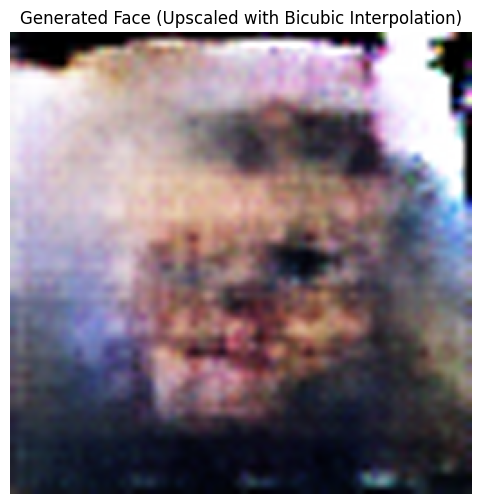

SimpleCNN Prediction:  Male
ResNet-18 Prediction:  Male


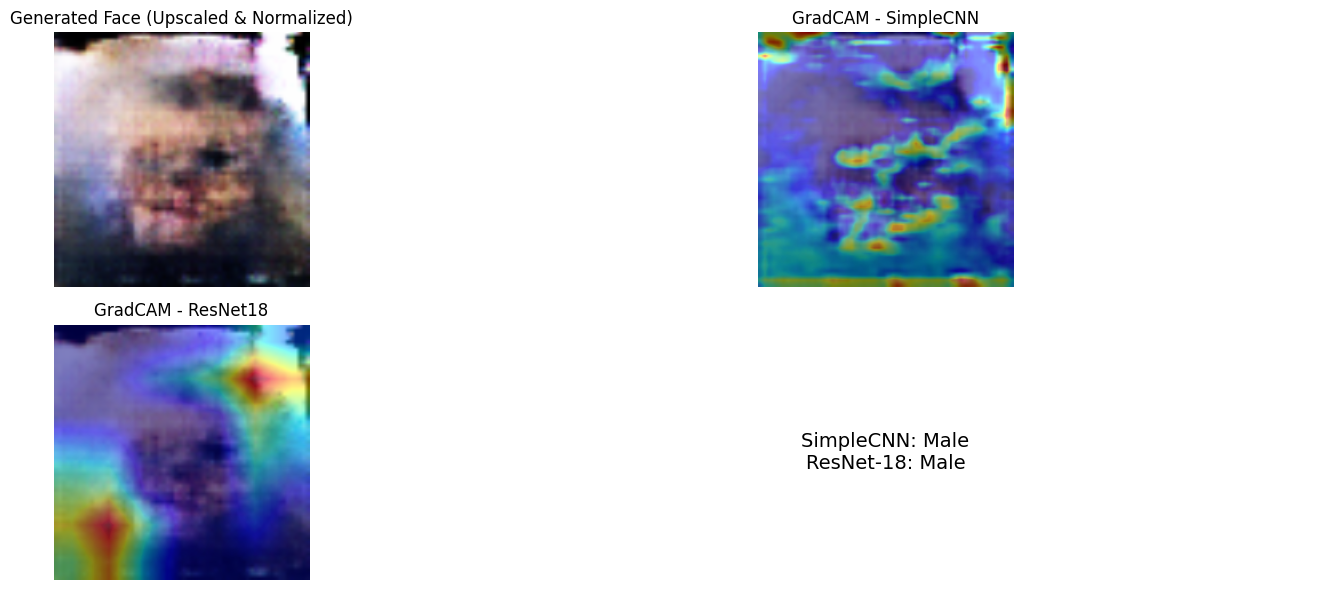

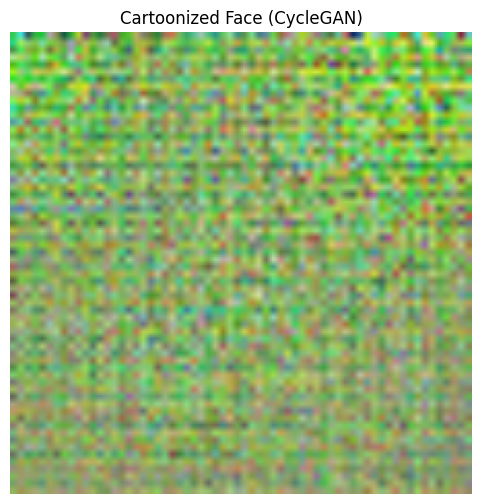

In [122]:
import torch
import torch.nn.functional as F
from torchvision.transforms import Resize, Normalize, Compose
import matplotlib.pyplot as plt
import numpy as np

# =======================
# STEP 1: Generate a New Face and Predict Gender
# =======================

# Assume nz (latent dimension) is 100 as used in DCGAN.
nz = 100  
noise = torch.randn(1, nz, 1, 1, device=device)

# Generate a new face from netG (DCGAN generator).
# netG outputs images with Tanh activation in the range [-1, 1].
gen_face = netG(noise)             # Shape: [1, 3, 64, 64]
gen_face = (gen_face + 1) / 2        # Scale to [0,1] for visualization




# Upsample to higher resolution using bicubic interpolation.
hr_size = (256, 256)  # Change as desired.
gen_face_hr = torch.nn.functional.interpolate(gen_face, size=hr_size, mode='bicubic', align_corners=False)

# Visualize the high-resolution generated face.
import matplotlib.pyplot as plt
img_hr = gen_face_hr.squeeze(0).cpu().permute(1, 2, 0).detach().numpy()
img_hr = np.clip(img_hr, 0, 1)
plt.figure(figsize=(6,6))
plt.imshow(img_hr)
plt.title("Generated Face (Upscaled with Bicubic Interpolation)")
plt.axis("off")
plt.show()


# To feed the generated face into our classification models, we need to:
# - Upsample it to the model input size (224x224)
# - Normalize it according to the model training (mean, std)
gen_face_resized = F.interpolate(gen_face, size=(224, 224), mode='bilinear', align_corners=False)

# Define a normalization transform (no conversion to tensor is needed since image is already a tensor)
normalize_transform = Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
# Apply normalization.
gen_face_norm = normalize_transform(gen_face_resized.squeeze(0)).unsqueeze(0)
gen_face_norm = gen_face_norm.to(device)

# Get predictions from both models.
model_scratch.eval()
model_pretrained.eval()
with torch.no_grad():
    output_scratch = model_scratch(gen_face_norm)
    output_pretrained = model_pretrained(gen_face_norm)

pred_scratch = int((torch.sigmoid(output_scratch) > 0.5).item())  # 0 means Female, 1 means Male.
pred_pretrained = int((torch.sigmoid(output_pretrained) > 0.5).item())

label_map = {0: "Female", 1: "Male"}
print("SimpleCNN Prediction: ", label_map[pred_scratch])
print("ResNet-18 Prediction: ", label_map[pred_pretrained])

# =======================
# STEP 1b: Setup GradCAM for Both Models
# =======================

# For SimpleCNN, choose a convolutional layer. For example, assume model_scratch.features[8] is a Conv2d.
target_layer_simple = model_scratch.features[8]   # Adjust if necessary.
gradcam_scratch = GradCAM(model_scratch, target_layer_simple)

# For ResNet-18, using a layer from the last block.
target_layer_resnet = model_pretrained.layer4[1].conv2  # Adjust as needed.
gradcam_resnet = GradCAM(model_pretrained, target_layer_resnet)

# Generate GradCAM heatmaps using the same normalized input.
cam_scratch = gradcam_scratch.generate_cam(gen_face_norm)
cam_resnet = gradcam_resnet.generate_cam(gen_face_norm)

# Denormalize the normalized generated face for visualization.
def denormalize(img_tensor):
    # img_tensor: [1, 3, 224, 224]
    img = img_tensor.squeeze(0).cpu().permute(1, 2, 0).detach().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

img_display = denormalize(gen_face_norm)

# Visualize the generated face and the GradCAM results.
plt.figure(figsize=(16, 6))
plt.subplot(2, 2, 1)
plt.imshow(img_display)
plt.title("Generated Face (Upscaled & Normalized)")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img_display)
plt.imshow(cam_scratch, cmap='jet', alpha=0.5)
plt.title("GradCAM - SimpleCNN")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(img_display)
plt.imshow(cam_resnet, cmap='jet', alpha=0.5)
plt.title("GradCAM - ResNet18")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.text(0.5, 0.5, f"SimpleCNN: {label_map[pred_scratch]}\nResNet-18: {label_map[pred_pretrained]}",
         fontsize=14, ha="center", va="center")
plt.axis('off')
plt.tight_layout()
plt.show()

# =======================
# STEP 2: Convert the Generated Face to a Cartoon via CycleGAN
# =======================

# The CycleGAN generator (netG_A2B) is assumed to map photos (domain A) to cartoons (domain B).
# CycleGAN networks usually expect inputs in the range [-1,1]. 
# Our netG output (before scaling) is already in [-1,1]. We use that directly.
gen_face_raw = netG(noise)          # [1, 3, 64, 64] in range [-1, 1]

# Make sure netG_A2B is on the same device as gen_face_raw.
netG_A2B = netG_A2B.to(device)

# Apply the CycleGAN generator.
cartoon_face = netG_A2B(gen_face_raw)  # Output should also be in [-1,1] if trained conventionally.
cartoon_face = (cartoon_face + 1) / 2    # Scale to [0,1] for visualization

# Optionally, upscale the cartoon image (e.g., to 224x224) for a better view.
cartoon_face_disp = F.interpolate(cartoon_face, size=(224, 224), mode='bilinear', align_corners=False)
cartoon_face_disp = cartoon_face_disp.squeeze(0).cpu().permute(1, 2, 0).detach().numpy()
cartoon_face_disp = np.clip(cartoon_face_disp, 0, 1)

plt.figure(figsize=(6, 6))
plt.imshow(cartoon_face_disp)
plt.title("Cartoonized Face (CycleGAN)")
plt.axis('off')
plt.show()



# -----------------------------
# App 2: Upload a NEW photo by user and Check Gender based on SimpleCNN and pre-trained RestNet-18 
# -----------------------------

In [109]:
# ===========================================================
# SECTION 1: Upload a Photo Using ipywidgets
# ===========================================================
from ipywidgets import FileUpload
from IPython.display import display
import io
from PIL import Image
import matplotlib.pyplot as plt

# Create a file upload widget that accepts image files.
upload_widget = FileUpload(accept='image/*', multiple=False)
display(upload_widget)

FileUpload(value=(), accept='image/*', description='Upload')

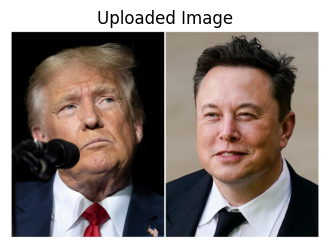

Using device: mps
SimpleCNN Prediction:  Male
ResNet-18 Prediction:  Male


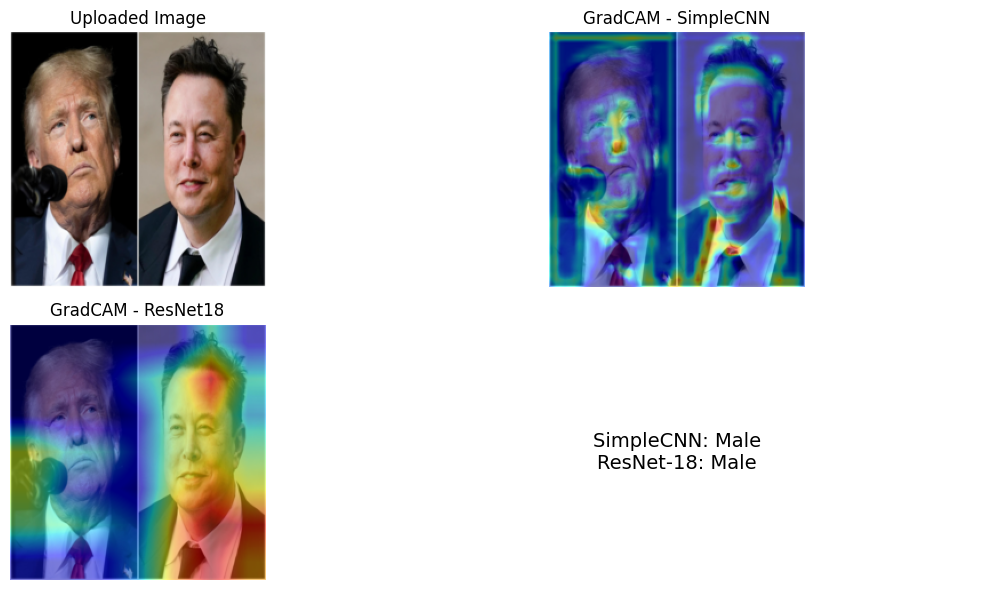

In [133]:


# Define a function to load the uploaded image.
def load_uploaded_image(widget):
    # Check if any file is uploaded.
    if not widget.value:
        raise ValueError("No file uploaded. Please upload an image file.")
    
    # widget.value might be a dictionary or a tuple/list.
    if isinstance(widget.value, dict):
        file_info = list(widget.value.values())[0]
    elif isinstance(widget.value, (tuple, list)):
        file_info = widget.value[0]
    else:
        raise ValueError("Unexpected type of widget.value")
    
    image_data = file_info['content']
    img = Image.open(io.BytesIO(image_data)).convert('RGB')
    return img

# Now load the uploaded image.
uploaded_image = load_uploaded_image(upload_widget)
plt.figure(figsize=(4,4))
plt.imshow(uploaded_image)
plt.title("Uploaded Image")
plt.axis('off')
plt.show()



# ===========================================================
# SECTION 2: Preprocess the Uploaded Image
# -----------------------------------------------------------
# We prepare two sets of transforms:
#  (a) For classification (for both models, input size 224x224, normalized as in training)
#  (b) For CycleGAN (input size 64x64, normalized to [-1,1])
# ===========================================================
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F

# Device setup (assumes models are already moved to device)
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
                      else "cpu")
print(f"Using device: {device}")

# (a) Preprocess for Classification (224x224, standard normalization)
classification_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# (b) Preprocess for CycleGAN (resize to 64x64; note: normalize to [-1,1] using mean=0.5 and std=0.5)
cyclegan_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Preprocessed tensors:
input_tensor = classification_transform(uploaded_image).unsqueeze(0).to(device)
cyclegan_input = cyclegan_transform(uploaded_image).unsqueeze(0).to(device)


# ===========================================================
# SECTION 3: Predict Gender with Both Models
# -----------------------------------------------------------
# The classification models output a single logit, where sigmoid(logit)>0.5 means "Male".
# -----------------------------------------------------------
# (Assumes model_scratch (SimpleCNN) and model_pretrained (ResNet-18) are defined & on device.)
model_scratch.eval()
model_pretrained.eval()
with torch.no_grad():
    output_scratch = model_scratch(input_tensor)
    output_pretrained = model_pretrained(input_tensor)

pred_scratch = int((torch.sigmoid(output_scratch) > 0.5).item())
pred_pretrained = int((torch.sigmoid(output_pretrained) > 0.5).item())

label_map = {0: "Female", 1: "Male"}
print("SimpleCNN Prediction: ", label_map[pred_scratch])
print("ResNet-18 Prediction: ", label_map[pred_pretrained])


# ===========================================================
# SECTION 4: Generate GradCAM Overlays for Both Models
# -----------------------------------------------------------
# We assume the GradCAM class is defined.
# For SimpleCNN, we select a convolutional layer from its sequential block.
# For ResNet-18, we choose a layer from its final block.
# -----------------------------------------------------------
# Example: For SimpleCNN, choose model_scratch.features[8] (adjust as needed).
target_layer_simple = model_scratch.features[8]  # Ensure this is a conv layer.
gradcam_scratch = GradCAM(model_scratch, target_layer_simple)

# For ResNet-18, choose an appropriate layer (e.g., layer4[1].conv2).
target_layer_resnet = model_pretrained.layer4[1].conv2
gradcam_resnet = GradCAM(model_pretrained, target_layer_resnet)

# Generate GradCAM heatmaps using the same classification input.
cam_scratch = gradcam_scratch.generate_cam(input_tensor)
cam_resnet = gradcam_resnet.generate_cam(input_tensor)

# Denormalize the input image for display.
import numpy as np
def denormalize(img_tensor):
    # Assumes img_tensor shape: [1, 3, 224, 224]
    img = img_tensor.squeeze(0).cpu().permute(1, 2, 0).detach().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

img_display = denormalize(input_tensor)

# Plot the GradCAM overlays along with predictions.
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(img_display)
plt.title("Uploaded Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img_display)
plt.imshow(cam_scratch, cmap='jet', alpha=0.5)
plt.title("GradCAM - SimpleCNN")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img_display)
plt.imshow(cam_resnet, cmap='jet', alpha=0.5)
plt.title("GradCAM - ResNet18")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.text(0.5, 0.5, 
         f"SimpleCNN: {label_map[pred_scratch]}\nResNet-18: {label_map[pred_pretrained]}",
         fontsize=14, ha="center", va="center")
plt.axis("off")
plt.tight_layout()
plt.show()


